# Subsidence Velocity $v$

@author: Max Felius

This notebook will provide the methodology for looking at the subsidence velocity and the ability to say something about it using the estimation variance.

## Roadmap
- Import the data
- Retrieve epochs into array
- plot the points
- implement a sinkhole in the last 5 epochs. Set a fixed R
- define a search grid
- Apply linear least squares to retrieve the xhat (v) and Qxhat (Qv). Set a fixed R.
- Do some research into the results

In [19]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time, os, sys, datetime, re
from scipy import spatial

In [206]:
#functions that are used throughout the notebook
def get_sentinel_epochs(header_list):
    filter_option = re.compile(r'd_\d{8}')
    epochs = list(filter(lambda x: filter_option.match(x) != None, header_list))  
    return epochs

def zg(R,r):
    return np.exp(-np.pi*(r**2/R**2))

def get_delta_day(epochs):
    '''
    Method for getting the time series
    '''
    dates = list(map(lambda x: datetime.datetime.strptime(x,'d_%Y%m%d'),epochs))
    start_date = dates[0]
    dates_days = np.array(list(map(lambda x: (x-start_date).days,dates)))

    return dates_days, start_date

def linear_model(x_vector,y_vector):
    A = x_vector
    y = y_vector
    
    A = A.reshape((1,len(y)))
    
    #stochastic matrix
    W = np.eye((len(y)))
    
    #compute solutions
    invW = np.linalg.inv(W)
    try:
        Qxhat = np.linalg.inv(A @ invW @ A.T)
    except:
        print('Exception...')
        return np.nan,np.nan,np.nan
    
    #the subsidence velocity
    xhat = Qxhat @ A @ invW @ y

    yhat1 = A.T @ xhat
    ehat = y - yhat1
    
#     fit = 100*(1-(np.sum(ehat @ ehat.T)/np.sum((y_data-np.mean(y_data))**2)))
    
    return xhat, Qxhat
    

def kinematic_model(R,r,y_data):
    '''
    Function to determine the subsidence velocity
    
    linear least squares
    '''
    #creating the LSQ
    A = zg(R,r) #len(x_range) by 1 matrix
    y = y_data

    A = A.reshape((1,len(y)))

    #stochastic matrix
    W = np.eye((len(y)))

    #compute solutions
    invW = np.linalg.inv(W)
    try:
        Qxhat = np.linalg.inv(A @ invW @ A.T)
    except:
        print('Exception...')
        return 0,0,0
    
    #the subsidence velocity
    xhat = Qxhat @ A @ invW @ y

    yhat1 = A.T @ xhat
    ehat = y - yhat1
    
    fit = 100*(1-(np.sum(ehat @ ehat.T)/np.sum((y_data-np.mean(y_data))**2)))
    
    return xhat, fit, Qxhat

#filter for extreme values
def filter_extremes(item,maxvalue=0.1,minvalue=0.0000001):
    if item == 0:
        return np.nan
    
    if item > maxvalue:
        return np.nan
#         return maxvalue
    if item < minvalue:
        return np.nan
#         return minvalue
    else:
        return item

In [238]:
#import the data
folder = ''
filename = 't88_points_Brunssum_r200.csv'

data = pd.read_csv(os.path.join(folder,filename))

#retrieve the epochs from the array
epoch_list = get_sentinel_epochs(list(data))

# #plot the points
# plt.figure(figsize=(15,10))
# plt.scatter(data['pnt_rdx'],data['pnt_rdy']);

#implement sinkhole in the last 5 epochs with fixed R
#sinkhole parameters
R = 50
x0 = 196400
y0 = 327800
# x0 = 196475
# y0 = 327840

# plt.scatter(x0,y0,marker='*',s=100)

maxsub = 0.5 #[m] -> 6 cm
d_days,s_day = get_delta_day(epoch_list[-5:])
v_init = maxsub/d_days[-1]

r = np.sqrt((data['pnt_rdx'].values-x0)**2+(data['pnt_rdy'].values-y0)**2)
idx = np.where(r<R)

for day,epoch in zip(d_days,epoch_list[-5:]):
    data[epoch].iloc[idx] = data[epoch].iloc[idx] - v_init*day*zg(R,r[idx])
    
# define a search grid
n = 300
x_range = np.linspace(min(data['pnt_rdx'].values),max(data['pnt_rdx'].values),n)
y_range = np.linspace(min(data['pnt_rdy'].values),max(data['pnt_rdy'].values),n)

xv,yv = np.meshgrid(x_range,y_range)

xv_u = xv.ravel()
yv_u = yv.ravel()

# plt.figure(figsize=(15,10))
# plt.scatter(xv,yv)

# Apply linear least squares to retrieve the xhat (v) and Qxhat (Qv). Set a fixed R.
#saving variables
xhat_save = np.zeros((5,len(xv_u)))
Qxhat_save = np.zeros((5,len(xv_u)))

#create kdtree
tree = spatial.cKDTree(data[['pnt_rdx','pnt_rdy']].values) 

i = 0
for xi,yi in zip(xv_u,yv_u):
    #apply to the last epoch
    subset = tree.query_ball_point([xi,yi],r=R)
    r_grid = np.sqrt((data['pnt_rdx'].values[subset]-xi)**2+(data['pnt_rdy'].values[subset]-yi)**2)

    for ii in range(5):
        if not len(r_grid)<=1:
            xhat, fit, Qxhat = kinematic_model(R,r_grid,data[epoch_list[int('-'+str(ii))]].values[subset])
        else:
            xhat, fit, Qxhat = [0],[0],[0]

    #     print(r_grid)
        #save the variables
        xhat_save[ii,i] = xhat[0]
        Qxhat_save[ii,i] = Qxhat[0]
    
    i+=1
    
# %% New block -------------------------------------------------------------

# Find a relation in the 5 epochs
# d_days
#saving variables
v_save = np.zeros((1,len(xv_u)))
Qv_save = np.zeros((1,len(xv_u)))

for i in range(len(xv_u)):
    vtemp, Qvtemp  = linear_model(d_days,xhat_save[:,i])
    v_save[0,i] = vtemp[0]
    Qv_save[0,i] = Qvtemp[0]

# %% New Block -------------------------------------------------------------    

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-206-8e483cb06208>:77: RuntimeWarning: invalid value encountered in double_scalars
  fit = 100*(1-(np.sum(ehat @ ehat.T)/np.sum((y_data-np.mean(y_data))**2)))
<ipython-input-206-8e483cb06208>:77: RuntimeWarning: divide by zero encountered in double_scalars
  fit = 100*(1-(np.sum(ehat @ ehat.T)/np.sum((y_data-np.mean(y_data))**2)))


[ 0  6 12 18 24]
0.020833333333333332 0.041666666666666664


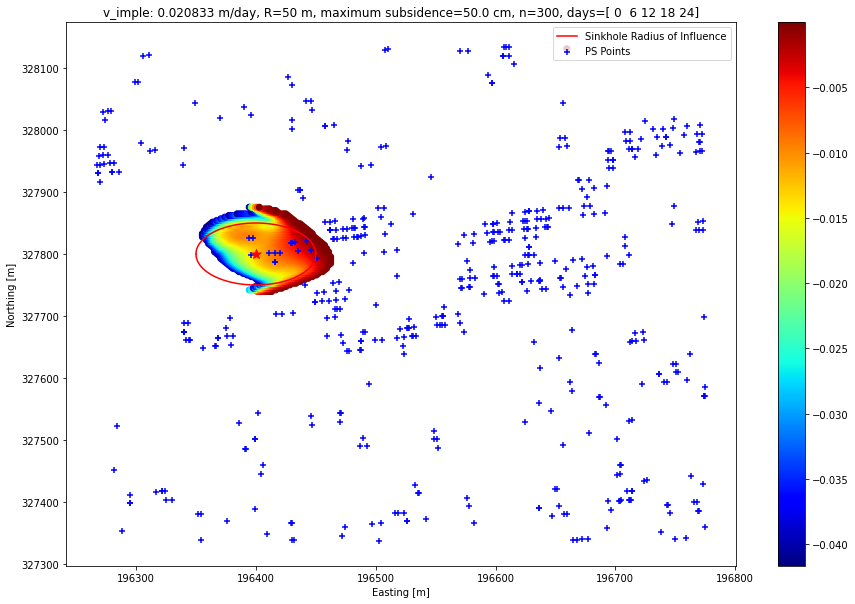

In [239]:
plt.figure(figsize=(15,10))
# plt.scatter(data['pnt_rdx'],data['pnt_rdy'],c='b',marker='+',label='PS Points');

filtered_v = list(map(lambda e: filter_extremes(e,maxvalue=0,minvalue=-v_init*2),v_save.reshape((len(xv_u),1))))

p = plt.scatter(xv_u,yv_u,c=filtered_v,cmap='jet')
plt.scatter(data['pnt_rdx'],data['pnt_rdy'],c='b',marker='+',label='PS Points');
plt.scatter(x0,y0,c='r',marker='*',s=100)
# plt.scatter(xv_u,yv_u)

#plot the radius of influence
x1 = np.linspace(x0-R,x0+R,500)
y1 = np.sqrt(R**2 - ((x1-x0)**2))+y0
y2 = y0 - np.sqrt(R**2 - ((x1-x0)**2))

#show the radius of influence
plt.plot(x1,y1,c='r')
plt.plot(x1,y2,c='r',label='Sinkhole Radius of Influence')


plt.title('v_imple: {:.06f} m/day, R={} m, maximum subsidence={} cm, n={}, days={}'.format(v_init,R,maxsub*100,n,d_days))
# plt.xlim([x0-R,x0+R])
# plt.ylim([y0-R,y0+R])
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.colorbar(p)
plt.legend()
print(d_days)
print(v_init,v_init*2)#,filtered_v)

In [240]:
#import the data
folder = ''
filename = 't88_points_Brunssum_r200.csv'

data = pd.read_csv(os.path.join(folder,filename))

#retrieve the epochs from the array
epoch_list = get_sentinel_epochs(list(data))

# #plot the points
# plt.figure(figsize=(15,10))
# plt.scatter(data['pnt_rdx'],data['pnt_rdy']);

#implement sinkhole in the last 5 epochs with fixed R
#sinkhole parameters
R = 50
# x0 = 196400
# y0 = 327800
x0 = 196475
y0 = 327840

# plt.scatter(x0,y0,marker='*',s=100)

maxsub = 0.5 #[m] -> 6 cm
d_days,s_day = get_delta_day(epoch_list[-5:])
v_init = maxsub/d_days[-1]

r = np.sqrt((data['pnt_rdx'].values-x0)**2+(data['pnt_rdy'].values-y0)**2)
idx = np.where(r<R)

for day,epoch in zip(d_days,epoch_list[-5:]):
    data[epoch].iloc[idx] = data[epoch].iloc[idx] - v_init*day*zg(R,r[idx])
    
# define a search grid
n = 300
x_range = np.linspace(min(data['pnt_rdx'].values),max(data['pnt_rdx'].values),n)
y_range = np.linspace(min(data['pnt_rdy'].values),max(data['pnt_rdy'].values),n)

xv,yv = np.meshgrid(x_range,y_range)

xv_u = xv.ravel()
yv_u = yv.ravel()

# plt.figure(figsize=(15,10))
# plt.scatter(xv,yv)

# Apply linear least squares to retrieve the xhat (v) and Qxhat (Qv). Set a fixed R.
#saving variables
xhat_save = np.zeros((5,len(xv_u)))
Qxhat_save = np.zeros((5,len(xv_u)))

#create kdtree
tree = spatial.cKDTree(data[['pnt_rdx','pnt_rdy']].values) 

i = 0
for xi,yi in zip(xv_u,yv_u):
    #apply to the last epoch
    subset = tree.query_ball_point([xi,yi],r=R)
    r_grid = np.sqrt((data['pnt_rdx'].values[subset]-xi)**2+(data['pnt_rdy'].values[subset]-yi)**2)

    for ii in range(5):
        if not len(r_grid)<=1:
            xhat, fit, Qxhat = kinematic_model(R,r_grid,data[epoch_list[int('-'+str(ii))]].values[subset])
        else:
            xhat, fit, Qxhat = [0],[0],[0]

    #     print(r_grid)
        #save the variables
        xhat_save[ii,i] = xhat[0]
        Qxhat_save[ii,i] = Qxhat[0]
    
    i+=1
    
# %% New block -------------------------------------------------------------

# Find a relation in the 5 epochs
# d_days
#saving variables
v_save = np.zeros((1,len(xv_u)))
Qv_save = np.zeros((1,len(xv_u)))

for i in range(len(xv_u)):
    vtemp, Qvtemp  = linear_model(d_days,xhat_save[:,i])
    v_save[0,i] = vtemp[0]
    Qv_save[0,i] = Qvtemp[0]

# %% New Block -------------------------------------------------------------    

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-206-8e483cb06208>:77: RuntimeWarning: invalid value encountered in double_scalars
  fit = 100*(1-(np.sum(ehat @ ehat.T)/np.sum((y_data-np.mean(y_data))**2)))
<ipython-input-206-8e483cb06208>:77: RuntimeWarning: divide by zero encountered in double_scalars
  fit = 100*(1-(np.sum(ehat @ ehat.T)/np.sum((y_data-np.mean(y_data))**2)))


[ 0  6 12 18 24]
0.020833333333333332 0.041666666666666664


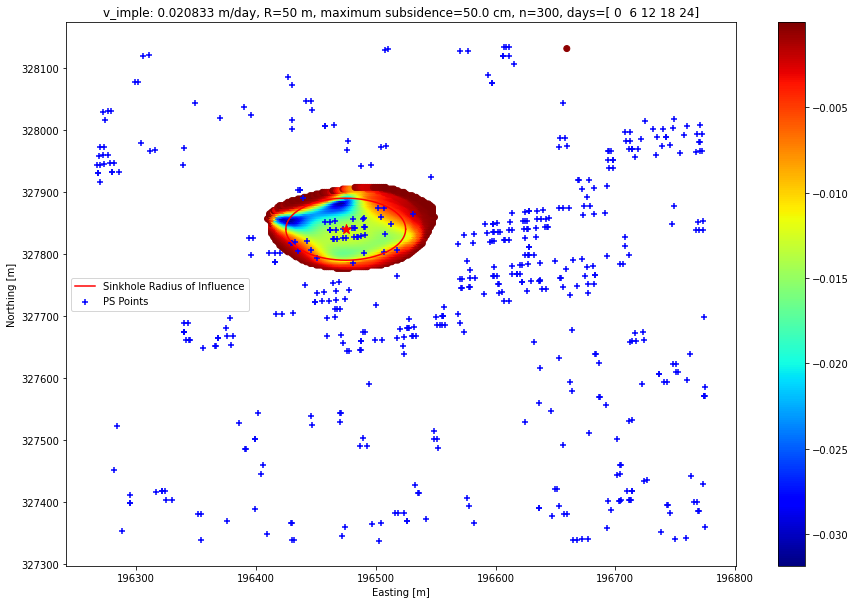

In [241]:
plt.figure(figsize=(15,10))
# plt.scatter(data['pnt_rdx'],data['pnt_rdy'],c='b',marker='+',label='PS Points');

filtered_v = list(map(lambda e: filter_extremes(e,maxvalue=0,minvalue=-v_init*2),v_save.reshape((len(xv_u),1))))

p = plt.scatter(xv_u,yv_u,c=filtered_v,cmap='jet')
plt.scatter(data['pnt_rdx'],data['pnt_rdy'],c='b',marker='+',label='PS Points');
plt.scatter(x0,y0,c='r',marker='*',s=100)
# plt.scatter(xv_u,yv_u)

#plot the radius of influence
x1 = np.linspace(x0-R,x0+R,500)
y1 = np.sqrt(R**2 - ((x1-x0)**2))+y0
y2 = y0 - np.sqrt(R**2 - ((x1-x0)**2))

#show the radius of influence
plt.plot(x1,y1,c='r')
plt.plot(x1,y2,c='r',label='Sinkhole Radius of Influence')


plt.title('v_imple: {:.06f} m/day, R={} m, maximum subsidence={} cm, n={}, days={}'.format(v_init,R,maxsub*100,n,d_days))
# plt.xlim([x0-R,x0+R])
# plt.ylim([y0-R,y0+R])
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.colorbar(p)
plt.legend()
print(d_days)
print(v_init,v_init*2)#,filtered_v)

In [256]:
#import the data
# https://nos.nl/artikel/2363529-auto-s-verdwenen-in-sinkhole-van-50-bij-50-meter-naast-italiaans-ziekenhuis.html
folder = ''
filename = 't88_points_Brunssum_r200.csv'

data = pd.read_csv(os.path.join(folder,filename))

#retrieve the epochs from the array
epoch_list = get_sentinel_epochs(list(data))

# #plot the points
# plt.figure(figsize=(15,10))
# plt.scatter(data['pnt_rdx'],data['pnt_rdy']);

#implement sinkhole in the last 5 epochs with fixed R
#sinkhole parameters
R = 20
# x0 = 196700
# y0 = 327700
x0 = 196630
y0 = 327850

# plt.scatter(x0,y0,marker='*',s=100)

maxsub = 0.05 #[m] -> 6 cm
d_days,s_day = get_delta_day(epoch_list[-5:])
v_init = maxsub/d_days[-1]

r = np.sqrt((data['pnt_rdx'].values-x0)**2+(data['pnt_rdy'].values-y0)**2)
idx = np.where(r<R)

for day,epoch in zip(d_days,epoch_list[-5:]):
    data[epoch].iloc[idx] = data[epoch].iloc[idx] - v_init*day*zg(R,r[idx])
    
# define a search grid
n = 300
x_range = np.linspace(min(data['pnt_rdx'].values),max(data['pnt_rdx'].values),n)
y_range = np.linspace(min(data['pnt_rdy'].values),max(data['pnt_rdy'].values),n)

xv,yv = np.meshgrid(x_range,y_range)

xv_u = xv.ravel()
yv_u = yv.ravel()

# plt.figure(figsize=(15,10))
# plt.scatter(xv,yv)

# Apply linear least squares to retrieve the xhat (v) and Qxhat (Qv). Set a fixed R.
#saving variables
xhat_save = np.zeros((5,len(xv_u)))
Qxhat_save = np.zeros((5,len(xv_u)))

#create kdtree
tree = spatial.cKDTree(data[['pnt_rdx','pnt_rdy']].values) 

i = 0
for xi,yi in zip(xv_u,yv_u):
    #apply to the last epoch
    subset = tree.query_ball_point([xi,yi],r=R)
    r_grid = np.sqrt((data['pnt_rdx'].values[subset]-xi)**2+(data['pnt_rdy'].values[subset]-yi)**2)

    for ii in range(5):
        if not len(r_grid)<=1:
            xhat, fit, Qxhat = kinematic_model(R,r_grid,data[epoch_list[int('-'+str(ii))]].values[subset])
        else:
            xhat, fit, Qxhat = [0],[0],[0]

    #     print(r_grid)
        #save the variables
        xhat_save[ii,i] = xhat[0]
        Qxhat_save[ii,i] = Qxhat[0]
    
    i+=1
    
# %% New block -------------------------------------------------------------

# Find a relation in the 5 epochs
# d_days
#saving variables
v_save = np.zeros((1,len(xv_u)))
Qv_save = np.zeros((1,len(xv_u)))

for i in range(len(xv_u)):
    vtemp, Qvtemp  = linear_model(d_days,xhat_save[:,i])
    v_save[0,i] = vtemp[0]
    Qv_save[0,i] = Qvtemp[0]

# %% New Block -------------------------------------------------------------    

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-206-8e483cb06208>:77: RuntimeWarning: invalid value encountered in double_scalars
  fit = 100*(1-(np.sum(ehat @ ehat.T)/np.sum((y_data-np.mean(y_data))**2)))
<ipython-input-206-8e483cb06208>:77: RuntimeWarning: divide by zero encountered in double_scalars
  fit = 100*(1-(np.sum(ehat @ ehat.T)/np.sum((y_data-np.mean(y_data))**2)))


[ 0  6 12 18 24]
0.0020833333333333333 0.004166666666666667


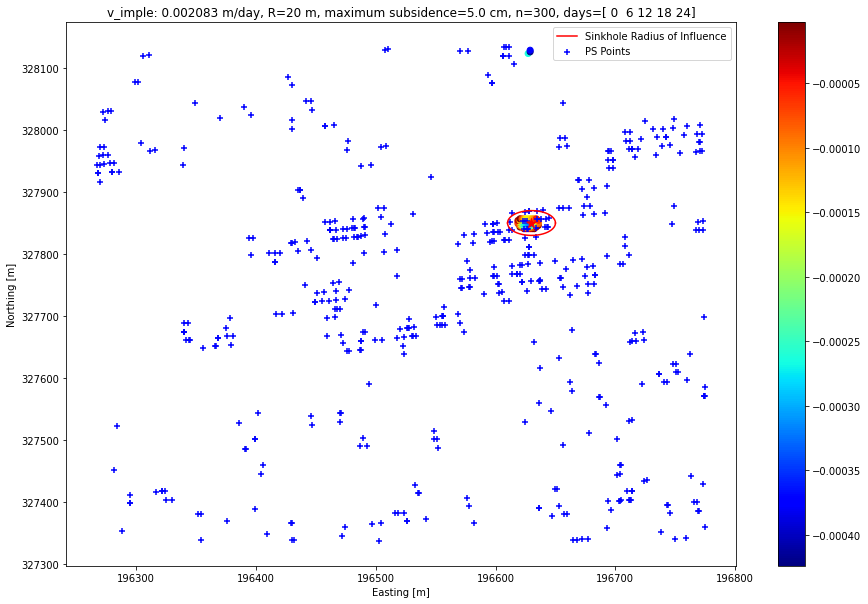

In [264]:
plt.figure(figsize=(15,10))
# plt.scatter(data['pnt_rdx'],data['pnt_rdy'],c='b',marker='+',label='PS Points');

filtered_v = list(map(lambda e: filter_extremes(e,maxvalue=0,minvalue=-v_init*2),v_save.T))

p = plt.scatter(xv_u,yv_u,c=filtered_v,cmap='jet')
plt.scatter(data['pnt_rdx'],data['pnt_rdy'],c='b',marker='+',label='PS Points');
plt.scatter(x0,y0,c='r',marker='*',s=100)
# plt.scatter(xv_u,yv_u)

#plot the radius of influence
x1 = np.linspace(x0-R,x0+R,500)
y1 = np.sqrt(R**2 - ((x1-x0)**2))+y0
y2 = y0 - np.sqrt(R**2 - ((x1-x0)**2))

#show the radius of influence
plt.plot(x1,y1,c='r')
plt.plot(x1,y2,c='r',label='Sinkhole Radius of Influence')


plt.title('v_imple: {:.06f} m/day, R={} m, maximum subsidence={} cm, n={}, days={}'.format(v_init,R,maxsub*100,n,d_days))
# plt.xlim([x0-R,x0+R])
# plt.ylim([y0-R,y0+R])
plt.xlabel('Easting [m]')
plt.ylabel('Northing [m]')
plt.colorbar(p)
plt.legend()
print(d_days)
print(v_init,v_init*2)#,filtered_v)

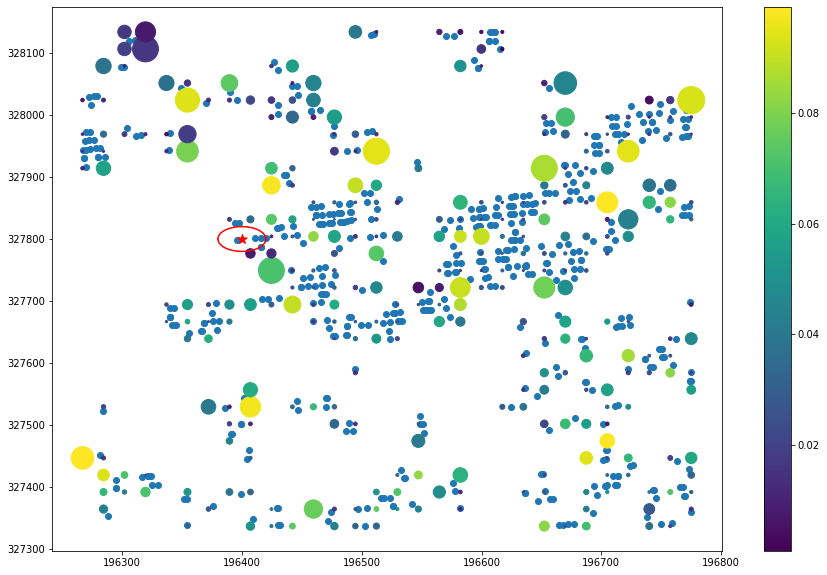

In [14]:
v_comp = np.array(list(map(filter_extremes,xhat_save[0])))
Qv_comp = np.array(list(map(lambda x: 10*filter_extremes(x,maxvalue=80),Qxhat_save[0])))

plt.figure(figsize=(15,10))
plt.scatter(data['pnt_rdx'],data['pnt_rdy']);
plt.scatter(x0,y0,c='r',marker='*',s=100)
p = plt.scatter(xv_u,yv_u,c=v_comp,s=Qv_comp)

#plot the radius of influence
x1 = np.linspace(x0-R,x0+R,500)
y1 = np.sqrt(R**2 - ((x1-x0)**2))+y0
y2 = y0 - np.sqrt(R**2 - ((x1-x0)**2))

#show the radius of influence
plt.plot(x1,y1,c='r')
plt.plot(x1,y2,c='r',label='Sinkhole Radius of Influence')

plt.colorbar(p);

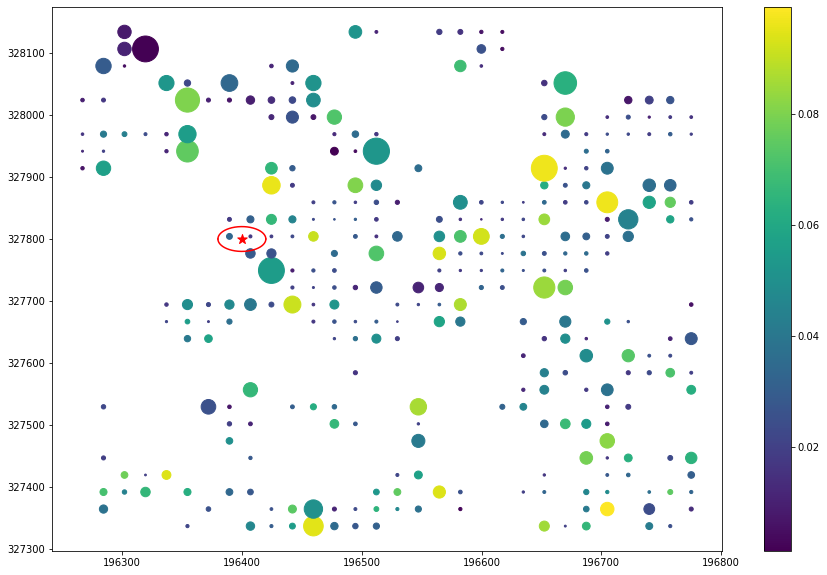

In [11]:
#saving variables
xhat_save = np.zeros((1,len(xv_u)))
Qxhat_save = np.zeros((1,len(xv_u)))

i = 0
for xi,yi in zip(xv_u,yv_u):
    #apply to the last epoch
    
    r_grid = np.sqrt((data['pnt_rdx'].values-xi)**2+(data['pnt_rdy'].values-yi)**2)
    
    xhat, fit, Qxhat = kinematic_model(R,r_grid,data[epoch_list[-10]])
    
    #save the variables
    xhat_save[0,i] = xhat[0]
    Qxhat_save[0,i] = Qxhat[0]
    
    i+=1

#filter for extreme values
def filter_extremes(item,maxvalue=0.1,minvalue=0.0000001):
    if item > maxvalue:
        return np.nan
#         return maxvalue
    if item < minvalue:
        return np.nan
#         return minvalue
    else:
        return item

v_comp = np.array(list(map(filter_extremes,xhat_save[0])))
Qv_comp = np.array(list(map(lambda x: 10*filter_extremes(x,maxvalue=80),Qxhat_save[0])))

plt.figure(figsize=(15,10))
# plt.scatter(data['pnt_rdx'],data['pnt_rdy'],marker='o');
plt.scatter(x0,y0,c='r',marker='*',s=100)
p = plt.scatter(xv_u,yv_u,c=v_comp,s=Qv_comp)

#plot the radius of influence
x1 = np.linspace(x0-R,x0+R,500)
y1 = np.sqrt(R**2 - ((x1-x0)**2))+y0
y2 = y0 - np.sqrt(R**2 - ((x1-x0)**2))

#show the radius of influence
plt.plot(x1,y1,c='r')
plt.plot(x1,y2,c='r',label='Sinkhole Radius of Influence')

plt.colorbar(p);

In [6]:
v_init

0.0025